# Task 2. Acyclic Graph Visualization

As in Task 1, we use **networkx** and **matplotlib** for graph processing and visualization. Also we use **numpy** and **scipy** for minimizing intersections between edges and dummy vertices.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
from scipy.optimize import linprog

from statistics import median
from math import floor

Here's our main class, which is responsible for processing and visualizing graph:

In [2]:
class DiGraph:
    def __init__(self, path: str):
        """
        Class for graph visualization
        :type path: str
        :param path: path of the graph file
        """
        self.G = nx.read_graphml(path)
        self.num_dict = dict()
        
        self.layers = [[]]
        
        for node in self.G.nodes:
            self.G.nodes[node]['pred_arr'] = [1e6 for _ in range(len(self.G.pred[node]))]
            self.G.nodes[node]['layer'] = None
            self.G.nodes[node]['is_dummy'] = False
            self.G.nodes[node]['label'] = node
            self.G.nodes[node]['x'] = 0.0
            
    def visualize(self, max_width=None):
        self.__top_sort()  # Run topological sort
        self.G = nx.relabel_nodes(self.G, self.num_dict)  # Rename vertices according to their order in topological sort
        
        if max_width is not None:
            # Graham - Coffman Algorithm
            self.__assign_layers(W=max_width)
        else:
            # Dummy vertices minimization algorithm
            self.__find_inital_layers()
            self.__discretise()
        
        self.__create_dummy_nodes()  # Create necessary dummy vertices
        self.__generate_start_x()  # Initialize horizontal coordinates for vertices
        self.__fix_layers()  # Minimize the number of edge intersections
        #self.beautify_x()  # Center the graph
        
    def __node_min_check(self, node1, node2) -> bool:
        """
        Checks if node1 is less than node2 lexicographically
        :param node1: name of node 1
        :param node2: name of node 2
        :return: True if node1 is less than node2 lexicographically, otherwise False
        :rtype: bool
        """
        node1_arr = self.G.nodes[node1]['pred_arr']
        node2_arr = self.G.nodes[node2]['pred_arr']
        
        for i in range(min(len(node1_arr), len(node2_arr))):
            if node1_arr[i] != node2_arr[i]:
                return node1_arr[i] > node2_arr[i]

        return len(node1_arr) > len(node2_arr)
   
    def __sort_generator(self):
        """
        Vertex generator for topological sort
        """
        for node in self.G.nodes:
            if len(self.G.pred[node]) == 0:
                yield node
        while True:
            min_node = None
            for node in self.G.nodes:
                if node not in self.num_dict.keys():
                    if min_node is None:
                        min_node = node
                    elif self.__node_min_check(min_node, node):
                        min_node = node
            yield min_node
        
    def __top_sort(self):
        """
        Vertex topological sort
        """
        num = 0
        elem_generator = self.__sort_generator()
        for _ in range(self.G.number_of_nodes()):
            node = next(elem_generator)
            self.num_dict[node] = num
            for succ_node in self.G.succ[node]:
                self.G.nodes[succ_node]['pred_arr'] = sorted(
                    self.G.nodes[succ_node]['pred_arr'][1:] + [num],
                    reverse=True
                )
            num += 1
    
    def __assign_layer_generator(self):
        """
        Vertex generator for assigning level numbers
        """
        while True:
            yield_node = None
            for node in reversed(range(len(self.G.nodes))):
                if self.G.nodes[node]['layer'] is not None:
                    continue
                has_unlayered_succs = any([self.G.nodes[succ]['layer'] is None for succ in self.G.succ[node]])
                if has_unlayered_succs:
                    continue
                yield_node = node
                break
            yield yield_node
            
    def __assign_layers(self, W):
        """
        Assigning a Level to Graph Vertices
        :param W:
        """
        elem_generator = self.__assign_layer_generator()
        for _ in range(self.G.number_of_nodes()):
            node = next(elem_generator)
            if len(self.G.succ[node]) > 0:
                layer_num = max([self.G.nodes[succ]['layer'] for succ in self.G.succ[node]]) + 1
            else:
                layer_num = 0
            
            while True:
                if layer_num == len(self.layers):
                    self.layers.append([])
                if len(self.layers[layer_num]) == W:
                    layer_num += 1
                else:
                    break

            self.layers[layer_num].append(node)
            self.G.nodes[node]['layer'] = layer_num
            
    def __find_inital_layers(self):
        """
        Solving a linear programming problem for finding the initial approximation of levels
        """
        n = len(self.G.nodes)
        m = len(self.G.edges)
        c = np.zeros(n)
        for u, v in self.G.edges:
            c[u] += 1
            c[v] -= 1
        
        A = np.zeros((m, n))
        b = np.zeros(m)
        for i, (u, v) in enumerate(self.G.edges):
            A[i, u] = -1
            A[i, v] = 1
            b[i] = -1
        bounds = [(0, None) for _ in self.G.nodes]
        layers = linprog(c, A_ub=A, b_ub=b, bounds=bounds)['x']
        
        for i, layer in enumerate(layers - np.min(layers)):
            self.G.nodes[i]['layer'] = layer
    
    def __discretise(self):
        """
        Discretization of the vertice levels taking into account the minimization of the number of dummy-vertices
        """
        nodes = sorted(self.G.nodes, key=lambda node: self.G.nodes[node]['layer'])
        for node in nodes:
            if len(self.G.succ[node]) > 0:
                self.G.nodes[node]['layer'] = int(max([
                    self.G.nodes[succ]['layer'] for succ in self.G.succ[node]
                ])) + 1 
            else:
                self.G.nodes[node]['layer'] = 0
        for node in nodes:
            if len(self.G.succ[node]) <= len(self.G.pred[node]) and len(self.G.pred[node]) != 0:
                self.G.nodes[node]['layer'] = min([self.G.nodes[pred]['layer'] for pred in self.G.pred[node]]) - 1
                
        num_layers = max([self.G.nodes[node]['layer'] for node in self.G.nodes])
        self.layers = [[] for _ in range(num_layers+1)]
        for node in self.G.nodes:
            self.layers[self.G.nodes[node]['layer']].append(node)        

    def __create_dummy_nodes(self):
        """
        Create dummy vertices in graph
        """
        edges_list = list(self.G.edges).copy()
        for u, v in edges_list:
            y_u, y_v = self.G.nodes[u]['layer'], self.G.nodes[v]['layer']            
            if y_u - y_v > 1:
                chain = [u]
                for i in reversed(range(y_v + 1, y_u)):
                    new_node_id = len(self.G.nodes)
                    self.G.add_node(new_node_id, layer=i, pred_arr=[], is_dummy=True, label=None, x=0.0)
                    chain.append(new_node_id)
                    self.layers[i].append(new_node_id)
                chain.append(v)
                self.G.remove_edge(u, v)
                for i in range(len(chain)-1):
                    self.G.add_edge(chain[i], chain[i+1])
                    
    def __generate_start_x(self):
        """
        Generating initial approximation of horizontal coordinates for vertices
        """
        for layer in reversed(self.layers):
            for node in layer:
                x_preds = [self.G.nodes[pred]['x'] for pred in self.G.pred[node]]
                if len(x_preds) > 0:
                    self.G.nodes[node]['x'] = floor(median(x_preds))
                else:
                    self.G.nodes[node]['x'] = 0
                
            layer_sorted = sorted(layer, key=lambda x: self.G.nodes[x]['x'])
            for i in range(len(layer_sorted)-1):
                node1 = layer_sorted[i]
                for j in range(i+1, len(layer_sorted)):
                    node2 = layer_sorted[j]
                    if self.G.nodes[node1]['x'] == self.G.nodes[node2]['x']:
                        self.G.nodes[node2]['x'] += 1
                
    def __calc_intersections(self, layer_num) -> int:
        """
        Counting the number of edge intersections between vertices from layers "layer_num" and "layer_num-1"
        :param layer_num: layer number
        :return: number of edge intersections
        :rtype: int
        """
        layer = self.layers[layer_num]
        intersections = 0
        for node_i in layer:
            x_i = self.G.nodes[node_i]['x']
            for node_j in layer:
                x_j = self.G.nodes[node_j]['x']
                if x_i < x_j:
                    for node_k in self.G.succ[node_i]:
                        x_k = self.G.nodes[node_k]['x']
                        for node_l in self.G.succ[node_j]:
                            x_l = self.G.nodes[node_l]['x']
                            if x_k > x_l:
                                intersections += 1
        return intersections
    
    def __apply_x(self, x_arr, layer_id):
        """
        Updating the horizontal coordinates of the level vertices
        """
        for x, node in zip(x_arr, self.layers[layer_id]):
            self.G.nodes[node]['x'] = x
    
    def __find_min_intersections(self, layer_id) -> bool:
        """
        Finding the local minimum of the number of intersections in the "layer_id"
        :param layer_id: number of layer
        :return: whether local minimum is found
        :rtype: bool
        """
        min_intersections = self.__calc_intersections(layer_id) + self.__calc_intersections(layer_id + 1)
        min_x_arr = [self.G.nodes[node]['x'] for node in self.layers[layer_id]]
        
        can_improve = True
        while can_improve:
            can_improve = False
            min_x_arr_step = min_x_arr.copy()
            
            for i in range(len(self.layers[layer_id]) - 1):
                for j in range(i + 1, len(self.layers[layer_id])):
                    x_arr = min_x_arr.copy()
                    x_arr[i], x_arr[j] = x_arr[j], x_arr[i]
                    self.__apply_x(x_arr, layer_id)
                    
                    new_intersections = self.__calc_intersections(layer_id) + self.__calc_intersections(layer_id + 1)
                    if new_intersections < min_intersections:
                        min_intersections = new_intersections
                        min_x_arr_step = x_arr
                        can_improve = True
                    self.__apply_x(min_x_arr, layer_id)
            
            min_x_arr = min_x_arr_step
            self.__apply_x(min_x_arr, layer_id)
        return can_improve
        
    def __fix_layers(self) -> None:
        """
        Minimizing the number of edge crossings for the entire graph
        """
        for _ in range(10):
            results = []
            for layer_id in range(1, len(self.layers)-1):
                results.append(self.__find_min_intersections(layer_id))
            
            for layer_id in reversed(range(1, len(self.layers)-1)):
                results.append(self.__find_min_intersections(layer_id))
            if any(results) == False:
                break
            
    def beautify_x(self):
        """
        Center the graph
        """
        for layer in self.layers:
            nodes_sorted = sorted(layer, key=lambda node: self.G.nodes[node]['x'])
            i_middle = len(nodes_sorted) // 2
            delta = len(nodes_sorted) % 2
            for i in range(len(nodes_sorted)):
                self.G.nodes[nodes_sorted[i]]['x'] = (1 - delta) + (i-i_middle)*2          
            
    def plot_digraph(self):
        """
        Graph visualization
        """
        x_arr = [self.G.nodes[node]['x'] for node in self.G.nodes if not self.G.nodes[node]['is_dummy']]
        y_arr = [self.G.nodes[node]['layer'] for node in self.G.nodes if not self.G.nodes[node]['is_dummy']]
        
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        
        ax.scatter(x_arr, y_arr, marker='o', s=100, c='blue')
        
        for start in self.G.nodes:
            for end in self.G.neighbors(start):
                x1 = self.G.nodes[start]['x']
                y1 = self.G.nodes[start]['layer']
                x2 = self.G.nodes[end]['x']
                y2 = self.G.nodes[end]['layer']

                ax.plot([x1,x2], [y1,y2], linestyle='-', color='black')
                
        for node in self.G.nodes:
            x = self.G.nodes[node]['x']
            y = self.G.nodes[node]['layer']
            label = self.G.nodes[node]['label']
            plt.text(
                x=x+0.1, y=y-0.1, s=label,
                fontdict=dict(color='red',size=20), bbox=dict(facecolor='yellow',alpha=0.5)
            )
                
        plt.axis('off')
        plt.show()

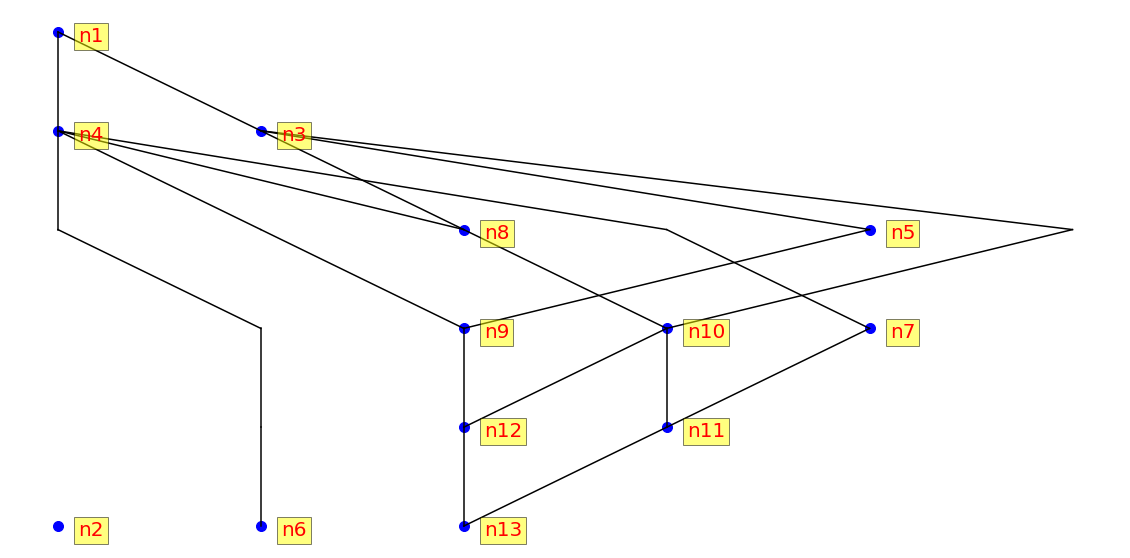

In [3]:
g = DiGraph(path='inputs/task2.xml')
g.visualize(max_width=3)
g.plot_digraph()

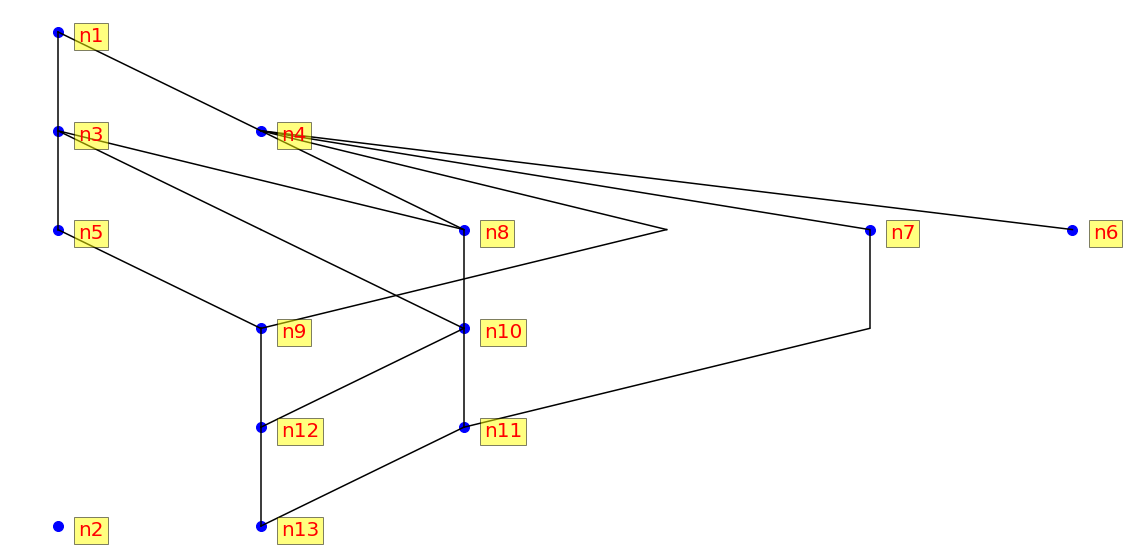

In [4]:
g = DiGraph(path='inputs/task2.xml')
g.visualize(max_width=None)
g.plot_digraph()